# 04 – Exploratory Data Analysis: Drivers of Late Returns

**Research focus:** What observable factors are associated with late returns in library borrowing records?

This notebook explores patterns in late returns with respect to:
- loan characteristics,
- temporal factors,
- media types,
- user categories.

The findings are used to motivate variables and hypotheses for subsequent modeling.


In [1]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [2]:
# --- load data ---
borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2313072, 21)


In [3]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"

DURATION_COL = "Leihdauer"
EXT_COL = "Anzahl_Verlängerungen"
LATE_FLAG_COL = "Verspätet"

MEDIA_TYPE_COL = "Medientyp"
USER_CATEGORY_COL = "Benutzerkategorie"

# timestamps
for c in [ISSUE_COL]:
    if c in borrowings.columns:
        borrowings[c] = pd.to_datetime(borrowings[c], errors="coerce")

# numeric columns
for c in [DURATION_COL]:
    if c in borrowings.columns:
        borrowings[c] = pd.to_numeric(borrowings[c], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")

In [4]:
late_rate = borrowings["late_bool"].mean()
print(f"Overall late rate: {late_rate:.2%}")

Overall late rate: 4.17%


## 1. Loan duration vs lateness

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_73975/4090028985.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(
/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_73975/4090028985.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


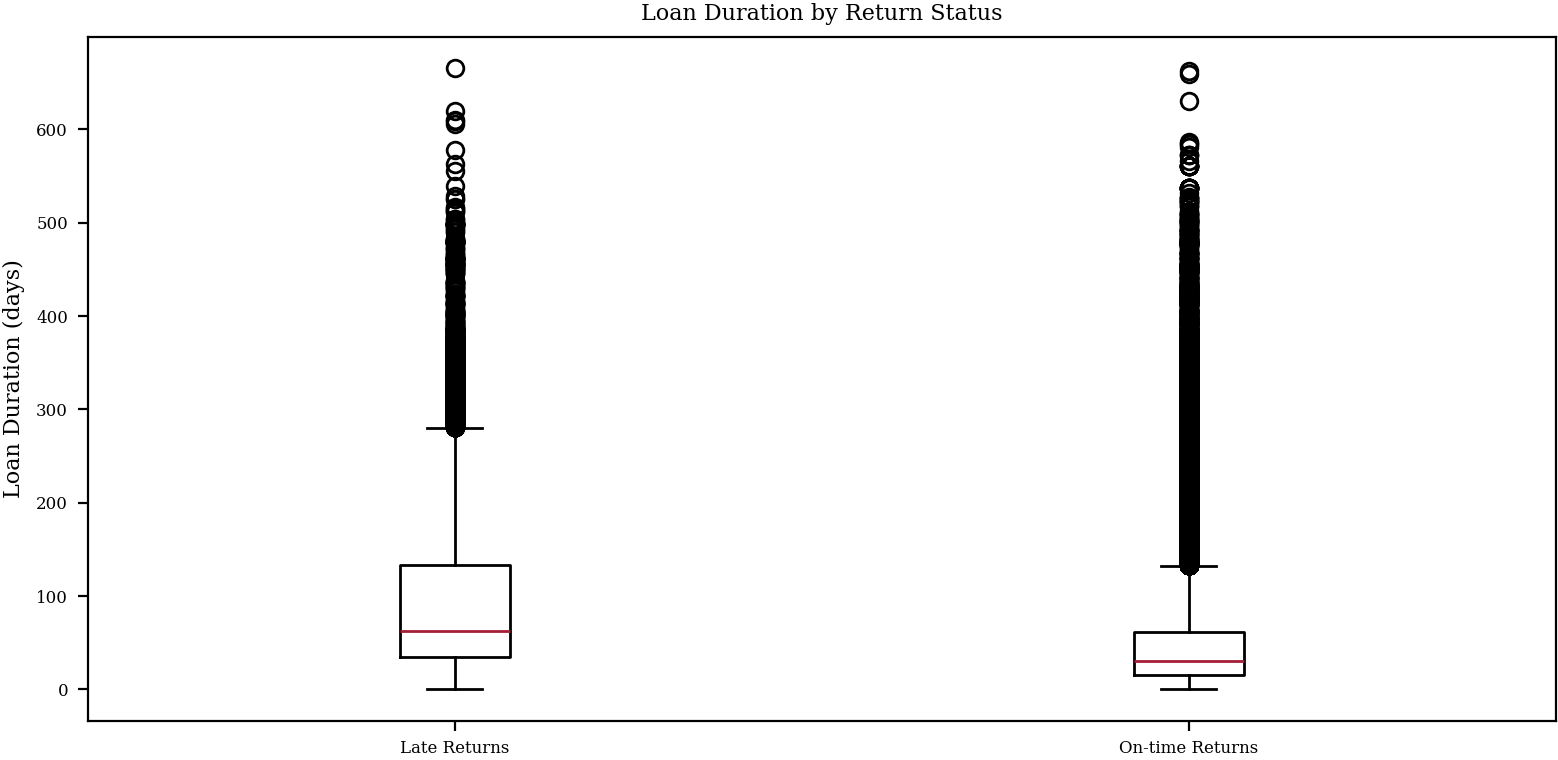

,count,mean,std,min,25%,50%,75%,max
late_bool,,,,,,,,
False,"2,216,538.0000",48.4476,50.5349,0.0000,15.0000,30.0000,62.0000,662.0000
True,"96,534.0000",93.8844,76.5540,1.0000,35.0000,63.0000,133.0000,666.0000


In [5]:
plt.figure(figsize=(8, 4))
plt.boxplot(
    [borrowings.loc[borrowings["late_bool"], DURATION_COL],
     borrowings.loc[~borrowings["late_bool"], DURATION_COL]],
    labels=["Late Returns", "On-time Returns"]
)

plt.ylabel("Loan Duration (days)")
plt.title("Loan Duration by Return Status")
plt.tight_layout()
plt.show()

borrowings.groupby("late_bool")[DURATION_COL].describe()

In [6]:
## --- investigate short late returns ---
#short_late = borrowings[(borrowings["late_bool"] == True) & (borrowings[DURATION_COL] <= 5)]
#print(f"Number of late returns with duration <= 5 days: {len(short_late)}")
#print("Sample of short late returns:")
#short_late[[MEDIA_TYPE_COL, USER_CATEGORY_COL, DURATION_COL, EXT_COL, ISSUE_COL]].head(70)

### Interpretatation to Loan Duration vs lateness ###

The figure and summary statistics compare loan durations for **late** and **on-time** returns.

Several clear differences emerge:

- **Higher typical loan duration for late returns:**  
  The median loan duration for late returns is **63 days**, compared to **30 days** for on-time returns. This indicates that loans held for longer periods are substantially more likely to be returned late.

- **Stronger right-skew and higher variability:**  
  Late returns show a much larger spread, with a higher standard deviation (≈73 days vs. ≈50 days). This suggests that late borrowing behavior is more heterogeneous, ranging from moderately extended loans to very long ones.

- **Shifted distribution rather than isolated extremes:**  
  Differences between late and on-time returns are not driven solely by a few extreme cases. The entire distribution of loan durations for late returns is shifted upward, as reflected by higher values at the 25th, 50th, and 75th percentiles.

- **Substantial overlap between groups:**  
  Despite these differences, the distributions overlap considerably. Many long loans are still returned on time, and some short loans are returned late. This indicates that loan duration alone does not fully determine lateness.

**Conclusion:**  
Loan duration is strongly associated with late returns and appears to be an important explanatory factor. However, the observed overlap suggests that additional factors—such as extensions, media type, or user category—are likely to play a role and should be considered in a multivariate analysis.


## 2. Extensions vs. lateness

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_73975/3910889654.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


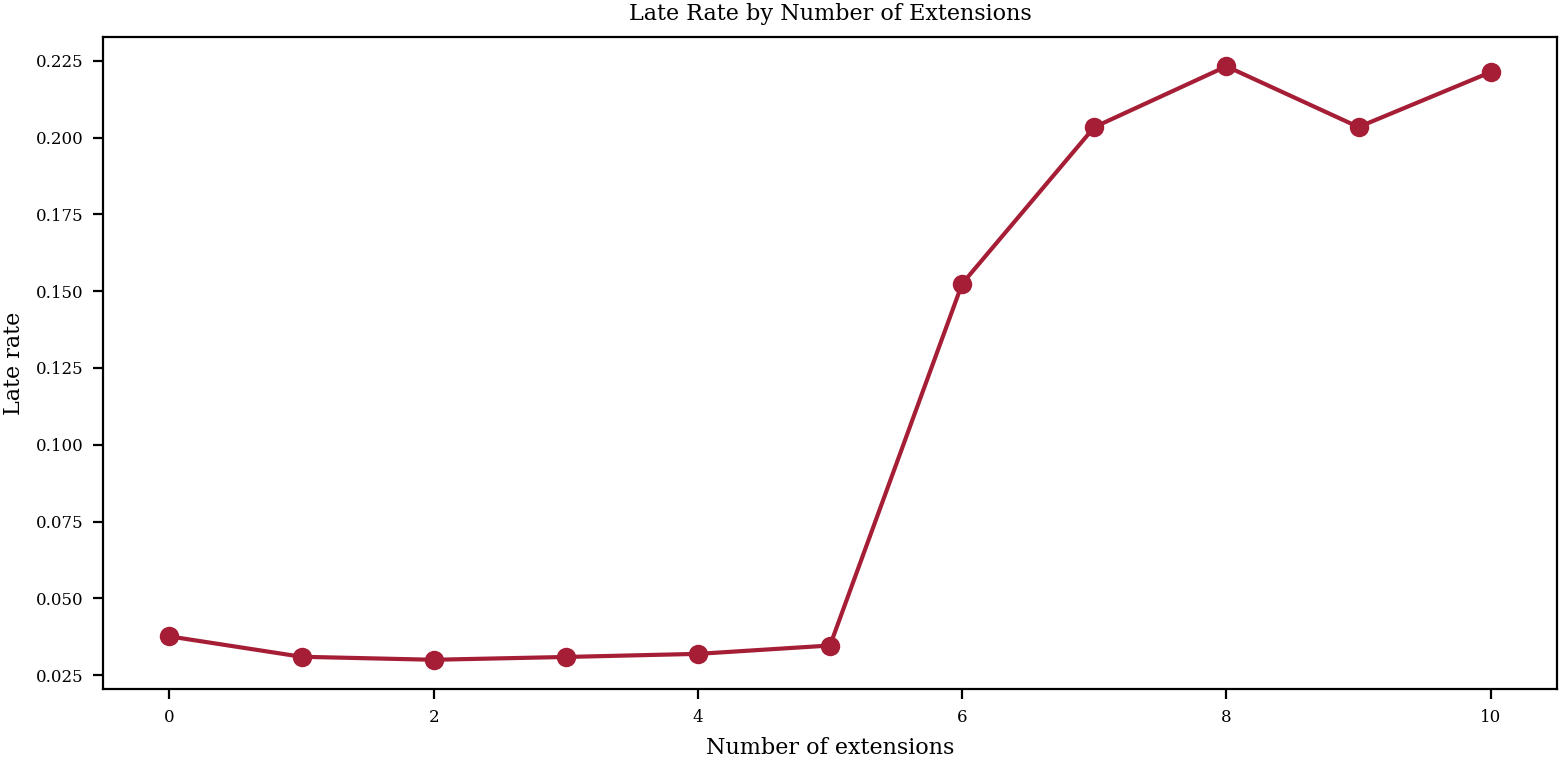

In [7]:
ext_summary = (
    borrowings.groupby(EXT_COL)["late_bool"]
    .agg(["mean","count"])
)

ext_summary

plot_df = ext_summary[ext_summary["count"] >= 100]

plt.figure(figsize=(8, 4))
plt.plot(plot_df.index, plot_df["mean"], marker="o")
plt.xlabel("Number of extensions")
plt.ylabel("Late rate")
plt.title("Late Rate by Number of Extensions")
plt.tight_layout()
plt.show()


### Interpretatation to Extensions vs lateness

The figure shows the late return rate as a function of the number of loan extensions.

Several distinct patterns emerge:

- **Low and stable late rates for few extensions:**  
  For loans with zero to five extensions, the late return rate remains low (around 3–4%) and relatively constant. This suggests that a small number of extensions does not substantially increase the risk of a late return.

- **Sharp increase after multiple extensions:**  
  Starting from six extensions, the late return rate rises abruptly, reaching values above 15% and peaking at more than 25%. This indicates a threshold effect rather than a gradual increase.

- **Plateau at high extension counts:**  
  For very high numbers of extensions, the late rate remains elevated but does not increase further, suggesting that once loans enter a high-extension regime, the probability of lateness is consistently high.

**Interpretation:**  
The number of extensions is strongly associated with late returns, particularly beyond a certain threshold. This pattern suggests that extensions may capture prolonged or problematic borrowing behavior and therefore represent a key explanatory variable for late returns.

**Implication for further analysis:**  
The non-linear relationship observed here motivates modeling approaches that allow for threshold or non-linear effects of extensions, rather than assuming a simple linear relationship.


## 3. Temporal factors to lateness

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_73975/1783549757.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


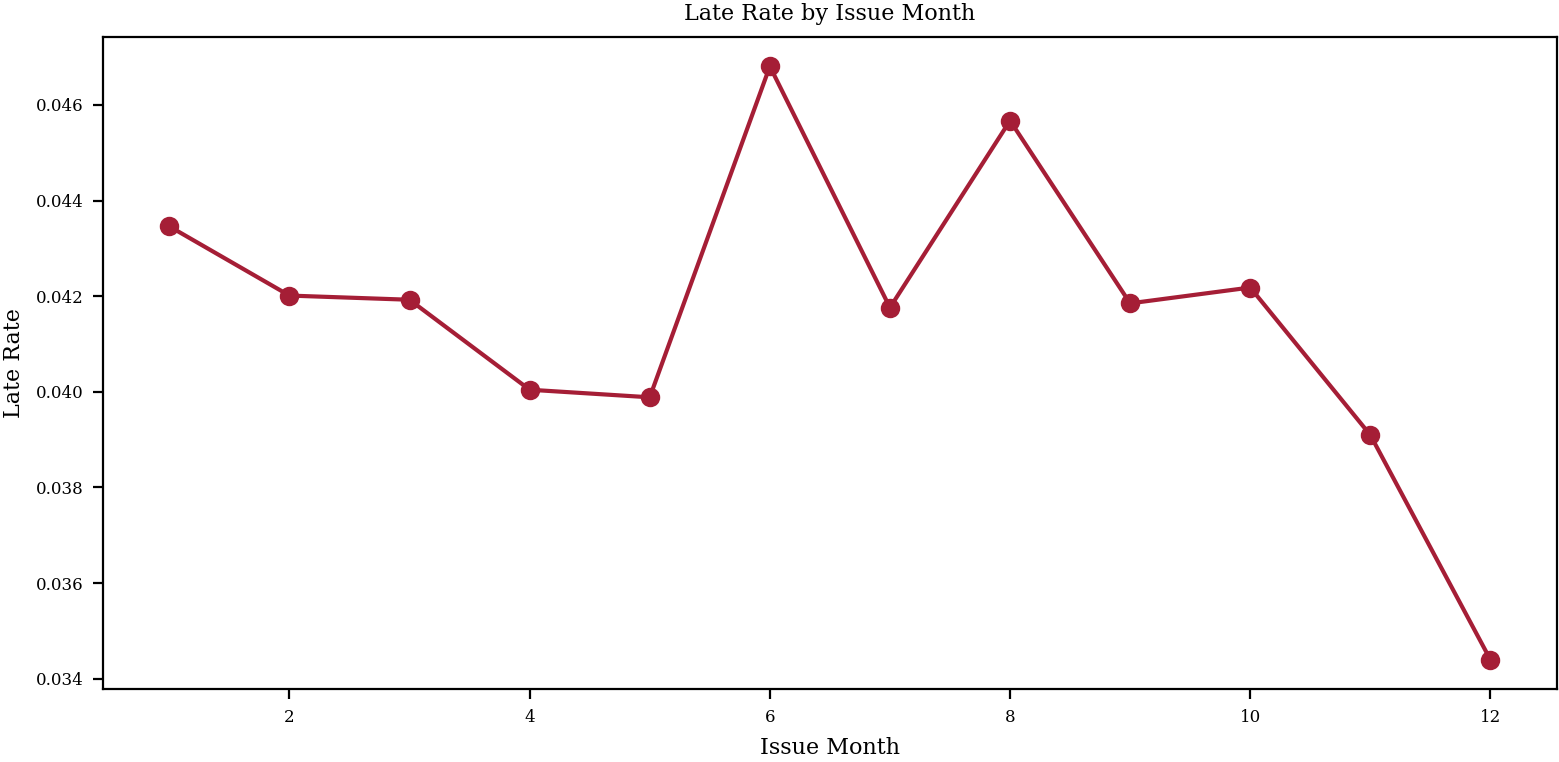

In [8]:
borrowings["isseue_month"] = borrowings[ISSUE_COL].dt.month

monthly_late = (
    borrowings.groupby("isseue_month")["late_bool"]
    .mean()
)

plt.figure(figsize=(8, 4))
plt.plot(monthly_late.index, monthly_late.values, marker="o")
plt.xlabel("Issue Month")
plt.ylabel("Late Rate")
plt.title("Late Rate by Issue Month")
plt.tight_layout()
plt.show()

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_73975/1878770590.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


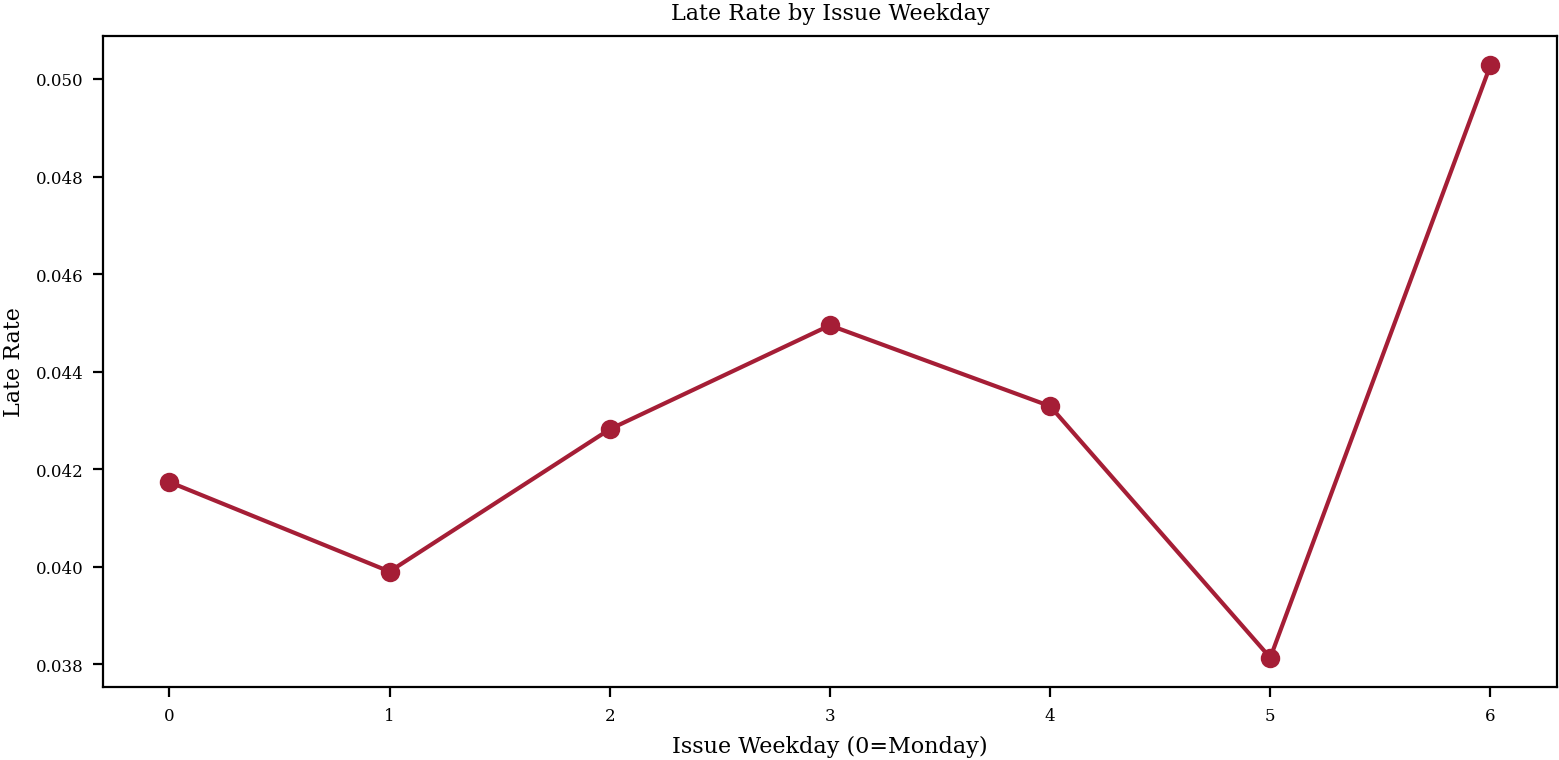

In [9]:
borrowings["issue_weekday"] = borrowings[ISSUE_COL].dt.weekday

weekly_late = (
    borrowings.groupby("issue_weekday")["late_bool"]
    .mean()
)

plt.figure(figsize=(8, 4))
plt.plot(weekly_late.index, weekly_late.values, marker="o")
plt.xlabel("Issue Weekday (0=Monday)")
plt.ylabel("Late Rate")
plt.title("Late Rate by Issue Weekday")
plt.tight_layout()
plt.show()

### Interpretation Temporal Factos

## 4. Late rate by media type

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_73975/1307416643.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


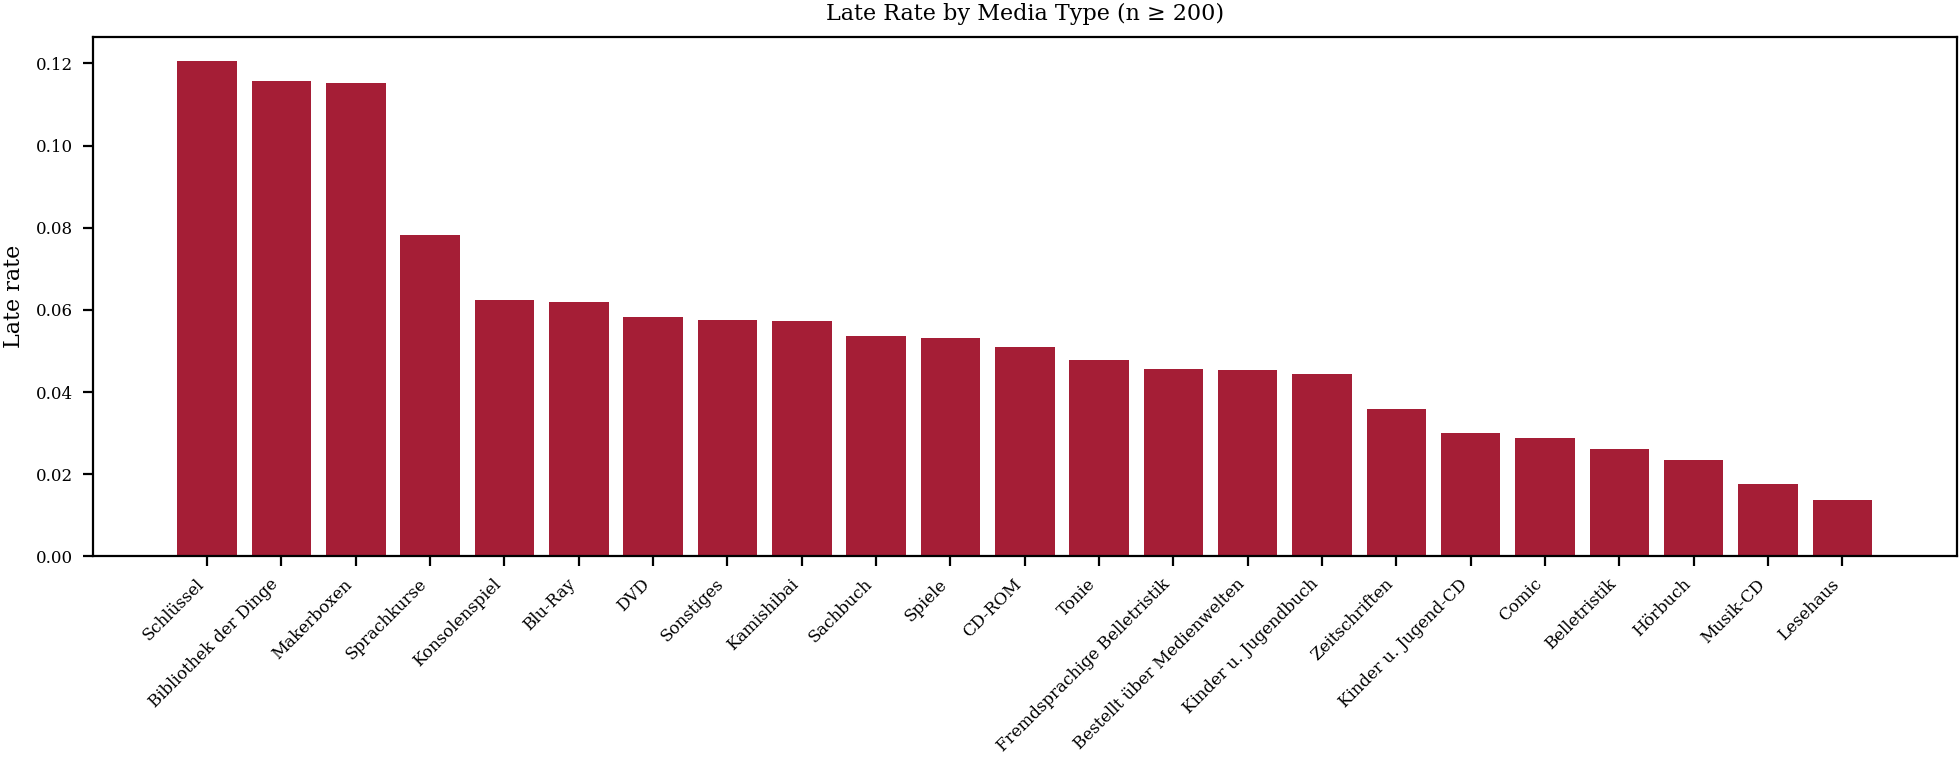

In [10]:
media_type_late = (
    borrowings.groupby(MEDIA_TYPE_COL)["late_bool"]
    .agg(["mean","count"])
    .sort_values(by="mean", ascending=False)
)

media_type_late.head(10)

plot_df = media_type_late[media_type_late["count"] >= 200]

plt.figure(figsize=(10, 4))
plt.bar(plot_df.index.astype(str), plot_df["mean"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Late rate")
plt.title("Late Rate by Media Type (n ≥ 200)")
plt.tight_layout()
plt.show()

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_73975/4214210536.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


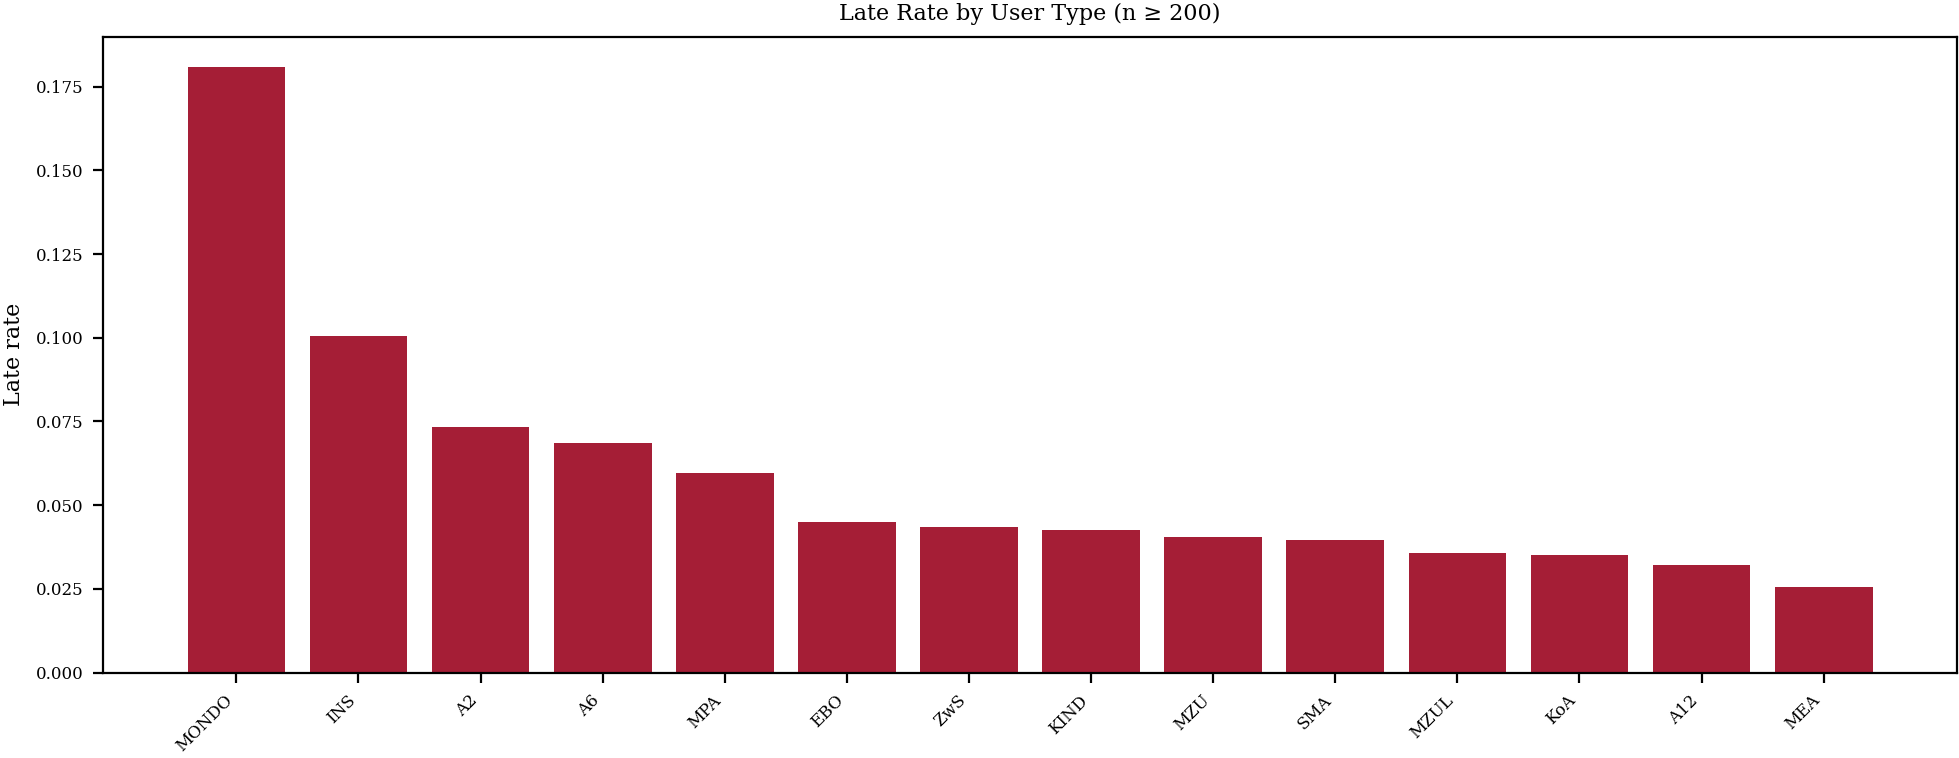

In [11]:
USER_CATEGORY_late = (
    borrowings.groupby(USER_CATEGORY_COL)["late_bool"]
    .agg(["mean","count"])
    .sort_values(by="mean", ascending=False)
)

USER_CATEGORY_late

plot_df = USER_CATEGORY_late[USER_CATEGORY_late["count"] >= 200]
plt.figure(figsize=(10, 4))
plt.bar(plot_df.index.astype(str), plot_df["mean"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Late rate")
plt.title("Late Rate by User Type (n ≥ 200)")
plt.tight_layout()
plt.show()